# Modèle initial : XGBoost sans traitement approfondi

Dans un premier temps, nous avons choisi d'entraîner un modèle XGBoost en utilisant l'ensemble des variables disponibles, afin d'obtenir un aperçu global des performances prédictives du jeu de données.

🔹 Objectifs de ce modèle exploratoire :

Évaluer rapidement la capacité prédictive des données sans passer par un prétraitement long

Identifier les variables les plus influentes grâce à l'importance des features fournie par XGBoost

Détecter les éventuelles surpromesses de certaines variables jugées "trop prédictives" (variables dites "magiques"). Certaines variables ont été conservées, même si elles semblaient suspectes de contenir une information trop liée à la cible (par exemple : etat).
L’idée est de les identifier plus clairement à travers l’analyse d’importance des features, puis de les retirer ou traiter différemment dans les itérations suivantes.


🔹 Traitement minimal appliqué :
Les variables catégorielles manquantes ont été mis en motif "missing".

Aucune sélection de variables n’a été effectuée

Cela nous permet de conserver toute l’information brute, y compris les éventuelles redondances

L'objectif est d’observer les performances du modèle sans biais induit par un filtrage prématuré



In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, TargetEncoder
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, classification_report, confusion_matrix


In [397]:
df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/processed/df_cleaned.csv')

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/4179772364.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/processed/df_cleaned.csv')


In [398]:
df.head()

,code_usage_auto,code_agent,code_formule,code_produit_gestion,prime_annuelle_ttc,code_marque_vehicule,libelle_modele_vehicule,numero_tarif,puissance_fiscale,rang_valeur_vehicule,...,code_marque_vehicule_groupe_1,numero_tarif_groupe,numero_tarif_groupe2,code_csp_groupe_1,code_csp_groupe_2,situation_familiale_binaire,region_groupe,etat_groupe,motif_resiliation_groupe,rang_valeur_vehicule_groupe
0,611.0,A00104,R,4190A,1929.66,PEUGEOT,205,BL050,D,5.0,...,tres_repandue,tres_courant_BL050,BL050,AUTRES,rare,marie,RA,ACTIF,motif_rare,Low
1,636.0,A00104,C,4190A,4106.44,PEUGEOT,309,BL064,K,10.0,...,tres_repandue,tres_courant_BL064,BL064,AUTRES,rare,marie,RA,ACTIF,motif_rare,Medium
2,611.0,A00104,C,4190A,4821.80,PEUGEOT,104,BL100,W,4.0,...,tres_repandue,modere,BL100,AUTRES,rare,marie,RA,ACTIF,motif_rare,Low
3,611.0,A00104,C,4190A,9460.74,RENAULT,CLIO,BL100,K,10.0,...,tres_repandue,modere,BL100,AUTRES,rare,non_marie,RA,ACTIF,motif_rare,Medium
4,603.0,A00104,S,4190A,1530.09,MERCEDES,300D 12313010,BL064,G,15.0,...,moyenne,tres_courant_BL064,BL064,AUTRES,rare,marie,RA,ACTIF,motif_rare,High


In [399]:
le = LabelEncoder()
df["contrat"]= le.fit_transform(df["contrat"])

In [400]:
df[["contrat"]]

,contrat
0,0
1,0
2,0
3,0
4,0
...,...
90242,0
90243,0
90244,0
90245,0


In [401]:
# Étape 1 : split train (60%) vs temp (40%)
df_train, df_temp = train_test_split(
    df, test_size=0.4, stratify=df["contrat"], random_state=42
)

# Étape 2 : split temp -> validation (20%) et test (20%)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp["contrat"], random_state=42
)

In [402]:
target = "contrat"
features = [col for col in df.columns if col != target]

# Pour l'entraînement
x_train = df_train[features]
y_train = df_train[target]

# Pour la validation
x_val = df_val[features]
y_val = df_val[target]

# Pour le test final
x_test = df_test[features]
y_test = df_test[target]


In [403]:
# aficher les tailles des ensembles
print(f"x_train {x_train.shape}")
print(f"x_val {x_val.shape}")
print(f"x_test{x_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_val {y_val.shape}")
print(f"y_test{y_test.shape}")

x_train (54148, 79)
x_val (18049, 79)
x_test(18050, 79)
y_train (54148,)
y_val (18049,)
y_test(18050,)


## 1. Encodage 

Pour l'encodage faire bien attention de faire fit sur train et transform sur train et test

In [404]:
var_cat = df.select_dtypes(include=['object']).columns

In [405]:
var_cat = [col for col in var_cat if col not in ['contrat', 'date_debut_contrat_converted', 'date_dernier_mouvement_converted',
       'date_obtention_permis_converted', 'date_mise_circulation_converted',
       'date_naissance_converted', 'anciennete_client_converted',
       'echeance_contrat_mmjj']]

In [406]:
var_cat = var_cat + ['premier_contrat','age_avant_mise_circulation', 'permis_avant_contrat','vehicule_avant_contrat']

In [407]:
var_cat

['code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'code_marche',
 'sexe',
 'situation_familiale',
 'departement',
 'region',
 'client_actif',
 'etat',
 'code_usage_auto_groupe',
 'libelle_modele_vehicule_groupe_1',
 'libelle_modele_vehicule_groupe_2',
 'code_agent_groupe',
 'code_formule_groupe',
 'code_produit_gestion_groupe',
 'code_marque_vehicule_groupe_2',
 'code_marque_vehicule_groupe_1',
 'numero_tarif_groupe',
 'numero_tarif_groupe2',
 'code_csp_groupe_1',
 'code_csp_groupe_2',
 'situation_familiale_binaire',
 'region_groupe',
 'etat_groupe',
 'motif_resiliation_groupe',
 'rang_valeur_vehicule_groupe',
 'premier_contrat',
 'age_avant_mise_circulation',
 'permis_avant_contrat',
 'vehicule_avant_contrat']

In [408]:
df[var_cat].isnull().sum()

code_agent                            0
code_formule                        545
code_produit_gestion                  0
code_marque_vehicule                 87
libelle_modele_vehicule             110
numero_tarif                        267
puissance_fiscale                   166
code_marche                           0
sexe                                100
situation_familiale                 360
departement                         199
region                              199
client_actif                          0
etat                                  0
code_usage_auto_groupe                0
libelle_modele_vehicule_groupe_1      0
libelle_modele_vehicule_groupe_2      0
code_agent_groupe                     0
code_formule_groupe                   0
code_produit_gestion_groupe           0
code_marque_vehicule_groupe_2         0
code_marque_vehicule_groupe_1         0
numero_tarif_groupe                   0
numero_tarif_groupe2                  0
code_csp_groupe_1                     0


In [409]:
# Remplacer les valeurs manquantes des variables catégorielles par "missing"
for col in var_cat:
    x_train[col] = x_train[col].fillna("missing").astype(str)
    x_test[col] = x_test[col].fillna("missing").astype(str)
    x_val[col] = x_val[col].fillna("missing").astype(str)

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/508327260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = x_train[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/508327260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[col] = x_test[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/508327260.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [410]:
df[var_cat].nunique()

code_agent                          1255
code_formule                          25
code_produit_gestion                   6
code_marque_vehicule                 256
libelle_modele_vehicule             6806
numero_tarif                          17
puissance_fiscale                     14
code_marche                            2
sexe                                   2
situation_familiale                    7
departement                          191
region                                11
client_actif                           2
etat                                   4
code_usage_auto_groupe                 3
libelle_modele_vehicule_groupe_1     101
libelle_modele_vehicule_groupe_2       2
code_agent_groupe                      4
code_formule_groupe                    7
code_produit_gestion_groupe            2
code_marque_vehicule_groupe_2         16
code_marque_vehicule_groupe_1          3
numero_tarif_groupe                    4
numero_tarif_groupe2                   7
code_csp_groupe_

### 1.1 Variable de temps

Lors de notre analyse exploratoire nous avons crée des variables à partir des dates : 'date_debut_contrat_converted','date_dernier_mouvement_converted','date_obtention_permis_converted', 'date_mise_circulation_converted','date_naissance_converted'.

Nous allons donc seulement utiliser les variables date_debut_contrat_converted, 'anciennete_client_converted' et 'echeance_contrat_mmjj dans notre modèle.

In [411]:
df[["date_debut_contrat_converted", "anciennete_client_converted", "echeance_contrat_mmjj"]].isnull().sum()/df.shape[0]

date_debut_contrat_converted    0.000000
anciennete_client_converted     0.000188
echeance_contrat_mmjj           0.000177
dtype: float64

In [412]:
# # Conversion des colonnes en datetime 
# x_train['date_debut_contrat_converted'] = pd.to_datetime(x_train['date_debut_contrat_converted'], errors='coerce')
# x_test['date_debut_contrat_converted'] = pd.to_datetime(x_test['date_debut_contrat_converted'], errors='coerce')
# x_val['date_debut_contrat_converted'] = pd.to_datetime(x_val['date_debut_contrat_converted'], errors='coerce')

# x_train['anciennete_client_converted'] = pd.to_datetime(x_train['anciennete_client_converted'], errors='coerce')
# x_test['anciennete_client_converted'] = pd.to_datetime(x_test['anciennete_client_converted'], errors='coerce')
# x_val['anciennete_client_converted'] = pd.to_datetime(x_val['anciennete_client_converted'], errors='coerce')

# x_train['echeance_contrat_mmjj'] = pd.to_datetime(x_train['echeance_contrat_mmjj'], format='%m-%d')
# x_test['echeance_contrat_mmjj'] = pd.to_datetime(x_test['echeance_contrat_mmjj'], format='%m-%d')
# x_val['echeance_contrat_mmjj'] = pd.to_datetime(x_val['echeance_contrat_mmjj'], format='%m-%d')

# # Création de nouvelles colonnes à partir des dates
# x_train['date_debut_annee'] = x_train['date_debut_contrat_converted'].dt.year
# x_test['date_debut_annee'] = x_test['date_debut_contrat_converted'].dt.year
# x_val['date_debut_annee'] = x_val['date_debut_contrat_converted'].dt.year

# x_train['date_debut_mois'] = x_train['date_debut_contrat_converted'].dt.month
# x_test['date_debut_mois'] = x_test['date_debut_contrat_converted'].dt.month
# x_val['date_debut_mois'] = x_val['date_debut_contrat_converted'].dt.month

# x_train['date_debut_jour'] = x_train['date_debut_contrat_converted'].dt.day
# x_test['date_debut_jour'] = x_test['date_debut_contrat_converted'].dt.day
# x_val['date_debut_jour'] = x_val['date_debut_contrat_converted'].dt.day

# x_train['date_debut_sin'] = np.sin(2 * np.pi * x_train['date_debut_contrat_converted'].dt.month / 12)
# x_test['date_debut_sin'] = np.sin(2 * np.pi * x_test['date_debut_contrat_converted'].dt.month / 12)
# x_val['date_debut_sin'] = np.sin(2 * np.pi * x_val['date_debut_contrat_converted'].dt.month / 12)

# x_train['date_debut_cos'] = np.cos(2 * np.pi * x_train['date_debut_contrat_converted'].dt.month / 12)
# x_test['date_debut_cos'] = np.cos(2 * np.pi * x_test['date_debut_contrat_converted'].dt.month / 12)
# x_val['date_debut_cos'] = np.cos(2 * np.pi * x_val['date_debut_contrat_converted'].dt.month / 12)




# x_train['anciennete_client_annee'] = x_train['anciennete_client_converted'].dt.year
# x_test['anciennete_client_annee'] = x_test['anciennete_client_converted'].dt.year
# x_val['anciennete_client_annee'] = x_val['anciennete_client_converted'].dt.year

# x_train['anciennete_client_mois'] = x_train['anciennete_client_converted'].dt.month
# x_test['anciennete_client_mois'] = x_test['anciennete_client_converted'].dt.month
# x_val['anciennete_client_mois'] = x_val['anciennete_client_converted'].dt.month

# x_train['anciennete_client_jour'] = x_train['anciennete_client_converted'].dt.day
# x_test['anciennete_client_jour'] = x_test['anciennete_client_converted'].dt.day
# x_val['anciennete_client_jour'] = x_val['anciennete_client_converted'].dt.day

# x_train['anciennete_client_sin'] = np.sin(2 * np.pi * x_train['anciennete_client_converted'].dt.month / 12)
# x_test['anciennete_client_sin'] = np.sin(2 * np.pi * x_test['anciennete_client_converted'].dt.month / 12)
# x_val['anciennete_client_sin'] = np.sin(2 * np.pi * x_val['anciennete_client_converted'].dt.month / 12)

# x_train['anciennete_client_cos'] = np.cos(2 * np.pi * x_train['anciennete_client_converted'].dt.month / 12)
# x_test['anciennete_client_cos'] = np.cos(2 * np.pi * x_test['anciennete_client_converted'].dt.month / 12)
# x_val['anciennete_client_cos'] = np.cos(2 * np.pi * x_val['anciennete_client_converted'].dt.month / 12)





# x_train['echeance_contrat_mois'] = x_train['echeance_contrat_mmjj'].dt.month
# x_test['echeance_contrat_mois'] = x_test['echeance_contrat_mmjj'].dt.month
# x_val['echeance_contrat_mois'] = x_val['echeance_contrat_mmjj'].dt.month

# x_train['echeance_contrat_jour'] = x_train['echeance_contrat_mmjj'].dt.day
# x_test['echeance_contrat_jour'] = x_test['echeance_contrat_mmjj'].dt.day
# x_val['echeance_contrat_jour'] = x_val['echeance_contrat_mmjj'].dt.day

# x_train['echeance_jour'] = x_train['echeance_contrat_mmjj'].dt.dayofyear # jour de l'année
# x_test['echeance_jour'] = x_test['echeance_contrat_mmjj'].dt.dayofyear
# x_val['echeance_jour'] = x_val['echeance_contrat_mmjj'].dt.dayofyear

# x_train['echeance_sin'] = np.sin(2 * np.pi * x_train['echeance_jour'] / 365)
# x_test['echeance_sin'] = np.sin(2 * np.pi * x_test['echeance_jour'] / 365)
# x_val['echeance_sin'] = np.sin(2 * np.pi * x_val['echeance_jour'] / 365)

# x_train['echeance_cos'] = np.cos(2 * np.pi * x_train['echeance_jour'] / 365)
# x_test['echeance_cos'] = np.cos(2 * np.pi * x_test['echeance_jour'] / 365)
# x_val['echeance_cos'] = np.cos(2 * np.pi * x_val['echeance_jour'] / 365)

### 1.2 Pour les variables à plus de 5 modalité faire CatBoost encoder (TargetEncoder)

In [413]:
var_plus_5_modalities = df[var_cat].nunique()[df[var_cat].nunique() > 5].index.tolist()
var_plus_5_modalities

['code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'situation_familiale',
 'departement',
 'region',
 'libelle_modele_vehicule_groupe_1',
 'code_formule_groupe',
 'code_marque_vehicule_groupe_2',
 'numero_tarif_groupe2',
 'code_csp_groupe_1',
 'region_groupe']

In [414]:
df.columns

Index(['code_usage_auto', 'code_agent', 'code_formule', 'code_produit_gestion',
       'prime_annuelle_ttc', 'code_marque_vehicule', 'libelle_modele_vehicule',
       'numero_tarif', 'puissance_fiscale', 'rang_valeur_vehicule',
       'nb_sinistres_2_ans_non_resp', 'nb_sinistres_3_ans_non_resp',
       'nb_sinistres_1_an_non_resp', 'nb_sinistres_0_an_non_resp',
       'nb_sinistres_3_ans_resp', 'nb_sinistres_2_ans_resp',
       'nb_sinistres_1_an_resp', 'nb_sinistres_0_an_resp',
       'niveau_bonus_malus', 'prime_reference', 'code_marche',
       'nb_contrats_resilies', 'code_csp', 'sexe', 'situation_familiale',
       'departement', 'region', 'nb_contrats_actifs',
       'nb_contrats_actifs_auto', 'nb_contrats_actifs_habitation',
       'nb_contrats_actifs_divers', 'nb_contrats_actifs_sante',
       'nb_contrats_actifs_vie', 'nb_contrats_auto_resilies',
       'nb_contrats_habitation_resilies', 'nb_contrats_sante_resilies',
       'nb_contrats_vie_resilies', 'nb_contrats_divers_resil

In [415]:
# Encodage CatBoostEncoder sur les variables à plus de 5 modalités
te = TargetEncoder()

x_train_te = pd.DataFrame(
    te.fit_transform(x_train[var_plus_5_modalities], y_train),
    columns=var_plus_5_modalities,
    index=x_train.index
)
x_val_te = pd.DataFrame(
    te.transform(x_val[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_val.index
)
x_test_te = pd.DataFrame(
    te.transform(x_test[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_test.index
)

x_train_te.head()


,code_agent,code_formule,code_produit_gestion,code_marque_vehicule,libelle_modele_vehicule,numero_tarif,puissance_fiscale,situation_familiale,departement,region,libelle_modele_vehicule_groupe_1,code_formule_groupe,code_marque_vehicule_groupe_2,numero_tarif_groupe2,code_csp_groupe_1,region_groupe
48482,0.128313,0.175868,0.112307,0.125990,0.147653,0.115076,0.146641,0.137347,0.099089,0.105212,0.147653,0.175868,0.125990,0.115076,0.130067,0.105212
42211,0.087387,0.073886,0.112313,0.106834,0.000000,0.101101,0.151624,0.103901,0.113352,0.123872,0.108237,0.073886,0.106834,0.101101,0.085991,0.123872
61658,0.150037,0.073496,0.112307,0.117521,0.148897,0.115076,0.097312,0.103545,0.128720,0.120710,0.148897,0.073496,0.117521,0.115076,0.081821,0.120710
40054,0.116592,0.073307,0.112302,0.098940,0.055235,0.117060,0.097684,0.135219,0.095694,0.123376,0.055235,0.073307,0.098940,0.117060,0.130564,0.123376
69667,0.127979,0.073358,0.112328,0.121491,0.049662,0.117123,0.100114,0.137474,0.153231,0.122247,0.049662,0.073358,0.121491,0.117123,0.130313,0.122247


### 1.3 Pour les variables à moins de 5 modalité faire one hot encoding ou order encoding (s'il y a un ordre)

In [416]:
var_moins_5_modalities = df[var_cat].nunique()[df[var_cat].nunique() <= 5].index.tolist()
var_moins_5_modalities

['code_marche',
 'sexe',
 'client_actif',
 'etat',
 'code_usage_auto_groupe',
 'libelle_modele_vehicule_groupe_2',
 'code_agent_groupe',
 'code_produit_gestion_groupe',
 'code_marque_vehicule_groupe_1',
 'numero_tarif_groupe',
 'code_csp_groupe_2',
 'situation_familiale_binaire',
 'etat_groupe',
 'motif_resiliation_groupe',
 'rang_valeur_vehicule_groupe',
 'premier_contrat',
 'age_avant_mise_circulation',
 'permis_avant_contrat',
 'vehicule_avant_contrat']

In [417]:
# One-hot encoding pour les variables à moins de 5 modalités
x_train_ohe = pd.get_dummies(x_train[var_moins_5_modalities], drop_first=True).astype(int)
x_val_ohe = pd.get_dummies(x_val[var_moins_5_modalities], drop_first=True).astype(int)
x_test_ohe = pd.get_dummies(x_test[var_moins_5_modalities], drop_first=True).astype(int)

In [418]:
x_train_ohe.head()

,code_marche_T,sexe_M,sexe_missing,client_actif_OUI,etat_RL,etat_SU,etat_TE,code_usage_auto_groupe_Usage_frequent,code_usage_auto_groupe_Usage_rare,libelle_modele_vehicule_groupe_2_tres_repandu,...,etat_groupe_RESIL,motif_resiliation_groupe_motif_majoritaire_1,motif_resiliation_groupe_motif_majoritaire_2,motif_resiliation_groupe_motif_rare,rang_valeur_vehicule_groupe_Low,rang_valeur_vehicule_groupe_Medium,premier_contrat_1,age_avant_mise_circulation_1,permis_avant_contrat_1,vehicule_avant_contrat_1
48482,0,1,0,1,0,0,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0
42211,1,1,0,1,1,0,0,1,0,0,...,1,1,0,0,1,0,1,0,0,0
61658,0,1,0,1,0,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,0
40054,0,1,0,1,0,0,0,0,1,1,...,0,0,0,1,0,1,1,0,0,0
69667,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,1,0,0,1


In [419]:
# regrouper les variables encodées
x_train_encoded = pd.concat([x_train_te, x_train_ohe], axis=1)
x_val_encoded = pd.concat([x_val_te, x_val_ohe], axis=1)
x_test_encoded = pd.concat([x_test_te, x_test_ohe], axis=1)


In [420]:
# cols_to_add = [
#     "date_debut_annee", "date_debut_mois", "date_debut_jour", "date_debut_sin", "date_debut_cos",
#     "anciennete_client_annee", "anciennete_client_mois", "anciennete_client_jour", "anciennete_client_sin", "anciennete_client_cos",
#     "echeance_contrat_mois", "echeance_contrat_jour", "echeance_sin", "echeance_cos"
# ]

# x_train_encoded = pd.concat([x_train_encoded, x_train[cols_to_add].reset_index(drop = True)], axis = 1)
# x_test_encoded = pd.concat([x_test_encoded, x_test[cols_to_add].reset_index(drop = True)], axis = 1)
# x_val_encoded = pd.concat([x_val_encoded, x_val[cols_to_add].reset_index(drop = True)], axis = 1)

In [421]:
var_num = df.columns.difference(var_cat + [target])
var_num

Index(['age_au_debut', 'age_mise_circ', 'age_optention_permis', 'age_vehicule',
       'anciennete_client_converted', 'code_csp', 'code_usage_auto',
       'coefficient_commission', 'coefficient_profil_tarif', 'crm',
       'date_debut_contrat_converted', 'date_dernier_mouvement_converted',
       'date_mise_circulation_converted', 'date_naissance_converted',
       'date_obtention_permis_converted', 'delai_dernier_mouvement',
       'delai_permis_contrat', 'echeance_contrat_mmjj', 'motif_resiliation',
       'nb_contrats_actifs', 'nb_contrats_actifs_auto',
       'nb_contrats_actifs_divers', 'nb_contrats_actifs_habitation',
       'nb_contrats_actifs_sante', 'nb_contrats_actifs_vie',
       'nb_contrats_auto_resilies', 'nb_contrats_divers_resilies',
       'nb_contrats_habitation_resilies', 'nb_contrats_resilies',
       'nb_contrats_sante_resilies', 'nb_contrats_vie_resilies',
       'nb_sinistres_0_an_non_resp', 'nb_sinistres_0_an_resp',
       'nb_sinistres_1_an_non_resp', 'nb_sini

In [422]:
# regrouper les variables continues aux variables catégorielles encodées
x_train_encoded = pd.concat([x_train_encoded, x_train[var_num]], axis=1)
x_val_encoded = pd.concat([x_val_encoded, x_val[var_num]], axis=1)
x_test_encoded = pd.concat([x_test_encoded, x_test[var_num]], axis=1)


In [423]:
# Retirer les variables de dates :
x_train_encoded = x_train_encoded.drop(columns=['date_debut_contrat_converted', 'date_dernier_mouvement_converted', 'date_obtention_permis_converted', 'date_mise_circulation_converted', 'date_naissance_converted', 'anciennete_client_converted', 'echeance_contrat_mmjj'])
x_val_encoded = x_val_encoded.drop(columns=['date_debut_contrat_converted', 'date_dernier_mouvement_converted', 'date_obtention_permis_converted', 'date_mise_circulation_converted', 'date_naissance_converted', 'anciennete_client_converted', 'echeance_contrat_mmjj'])
x_test_encoded = x_test_encoded.drop(columns=['date_debut_contrat_converted', 'date_dernier_mouvement_converted', 'date_obtention_permis_converted', 'date_mise_circulation_converted', 'date_naissance_converted', 'anciennete_client_converted', 'echeance_contrat_mmjj'])

In [424]:
x_train_encoded.head(10)

,code_agent,code_formule,code_produit_gestion,code_marque_vehicule,libelle_modele_vehicule,numero_tarif,puissance_fiscale,situation_familiale,departement,region,...,nb_sinistres_1_an_resp,nb_sinistres_2_ans_non_resp,nb_sinistres_2_ans_resp,nb_sinistres_3_ans_non_resp,nb_sinistres_3_ans_resp,niveau_bonus_malus,prime_annuelle_ttc,prime_reference,rang_valeur_vehicule,score_u
48482,0.128313,0.175868,0.112307,0.125990,0.147653,0.115076,0.146641,0.137347,0.099089,0.105212,...,NaN,NaN,NaN,NaN,NaN,60,1193.56,1575.0,4.0,0.251415
42211,0.087387,0.073886,0.112313,0.106834,0.000000,0.101101,0.151624,0.103901,0.113352,0.123872,...,NaN,NaN,NaN,NaN,NaN,50,1542.67,2272.0,2.0,0.676367
61658,0.150037,0.073496,0.112307,0.117521,0.148897,0.115076,0.097312,0.103545,0.128720,0.120710,...,NaN,NaN,NaN,NaN,NaN,50,3458.72,6790.0,9.0,0.171327
40054,0.116592,0.073307,0.112302,0.098940,0.055235,0.117060,0.097684,0.135219,0.095694,0.123376,...,NaN,NaN,NaN,NaN,NaN,80,9713.12,12147.0,11.0,0.311675
69667,0.127979,0.073358,0.112328,0.121491,0.049662,0.117123,0.100114,0.137474,0.153231,0.122247,...,NaN,NaN,NaN,NaN,NaN,54,4779.10,9799.0,11.0,0.485615
81579,0.068811,0.074343,0.112264,0.109445,0.092891,0.078453,0.126566,0.102712,0.094847,0.119683,...,NaN,NaN,NaN,NaN,NaN,50,3782.76,7764.0,6.0,0.107146
19433,0.064440,0.073886,0.112313,0.106834,0.183429,0.078224,0.122747,0.103901,0.082456,0.112354,...,NaN,NaN,NaN,NaN,NaN,50,2638.66,6555.0,9.0,0.890022
80810,0.156306,0.073496,0.112307,0.117521,0.096885,0.079536,0.123982,0.103545,0.136206,0.113432,...,NaN,NaN,NaN,NaN,NaN,50,2565.78,4148.0,5.0,0.919657
53697,0.237013,0.073886,0.112313,0.046600,0.161003,0.078224,0.107625,0.103901,0.115562,0.112354,...,NaN,NaN,NaN,NaN,NaN,50,2105.61,5981.0,9.0,0.305314
62087,0.000000,0.074343,0.112264,0.083981,0.000000,0.078453,0.090732,0.138476,0.098162,0.119683,...,NaN,2.0,1.0,NaN,NaN,50,5307.52,12685.0,14.0,0.576462


## 2. Modelisation

### 2.1 Modélisation complète (avec toutes les variables)

In [425]:
### Modèle d'initialisation 
xgb_model = XGBClassifier(
                objective="multi:softmax",
                num_class=2,
                booster="gbtree",
                eval_metric="mlogloss"
)

In [426]:
xgb_model.fit(x_train_encoded, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [427]:
y_pred_proba = xgb_model.predict_proba(x_test_encoded)

In [428]:
initial_log_loss = log_loss(y_test, y_pred_proba)
print("Log Loss initiale :", initial_log_loss)


Log Loss initiale : 0.0006931066396652788


In [429]:
y_pred = xgb_model.predict(x_test_encoded)

In [430]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))

    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Cancelled', 'Cancelled'], yticklabels=['Not Cancelled', 'Cancelled'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16024
           1       1.00      1.00      1.00      2026

    accuracy                           1.00     18050
   macro avg       1.00      1.00      1.00     18050
weighted avg       1.00      1.00      1.00     18050



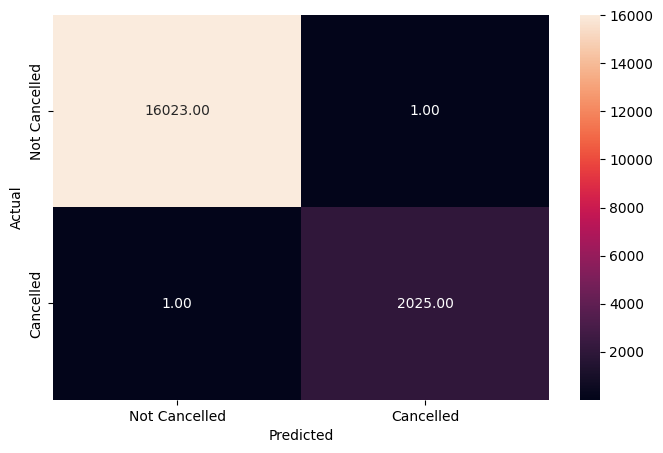

In [431]:
metrics_score(y_test, y_pred)

Nous observons que notre modèle présente des performances anormalement élevées, ce qui peut indiquer un surapprentissage ou une fuite de données. Cette situation suggère que certaines variables dites « magiques » pourraient introduire des informations qui, en réalité, ne seraient pas disponibles au moment de la prédiction en production.

En particulier, des variables comme etat, etat_groupe ou client_actif semblent fortement corrélées avec la variable cible contrat. Or, dans un contexte opérationnel réel, ces variables ne seraient connues qu'après qu’un contrat ait été signé ou validé.

Ainsi, inclure ces variables dans l'entraînement revient à donner au modèle une information qu’il ne devrait pas avoir au moment de la décision. Cela biaise les résultats, fausse l’évaluation du modèle, et peut donner une fausse impression de performance.

Pour garantir une évaluation honnête et un modèle généralisable, nous devons retirer ces variables du jeu d’entraînement. Cela permettra au modèle d’apprendre uniquement à partir d’informations disponibles au moment de la prédiction, conformément à un usage en conditions réelles.

### 2.1 Modélisation complète (avec toutes les variables)

In [432]:
x_train_encoded = x_train_encoded.drop(columns=['etat_RL', 'etat_SU', 'etat_TE', 'client_actif_OUI','etat_groupe_RESIL'])
x_val_encoded = x_val_encoded.drop(columns=['etat_RL', 'etat_SU', 'etat_TE', 'client_actif_OUI','etat_groupe_RESIL'])
x_test_encoded = x_test_encoded.drop(columns=['etat_RL', 'etat_SU', 'etat_TE', 'client_actif_OUI','etat_groupe_RESIL'])

In [433]:
### Modèle d'initialisation 
xgb_model = XGBClassifier(
                objective="multi:softmax",
                num_class=2,
                booster="gbtree",
                eval_metric="mlogloss"
)

In [434]:
xgb_model.fit(x_train_encoded, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [435]:
y_pred_proba = xgb_model.predict_proba(x_test_encoded)

In [436]:
initial_log_loss = log_loss(y_test, y_pred_proba)
print("Log Loss initiale :", initial_log_loss)


Log Loss initiale : 0.0019229644481056516


In [437]:
y_pred = xgb_model.predict(x_test_encoded)

In [438]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))

    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Cancelled', 'Cancelled'], yticklabels=['Not Cancelled', 'Cancelled'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16024
           1       1.00      1.00      1.00      2026

    accuracy                           1.00     18050
   macro avg       1.00      1.00      1.00     18050
weighted avg       1.00      1.00      1.00     18050



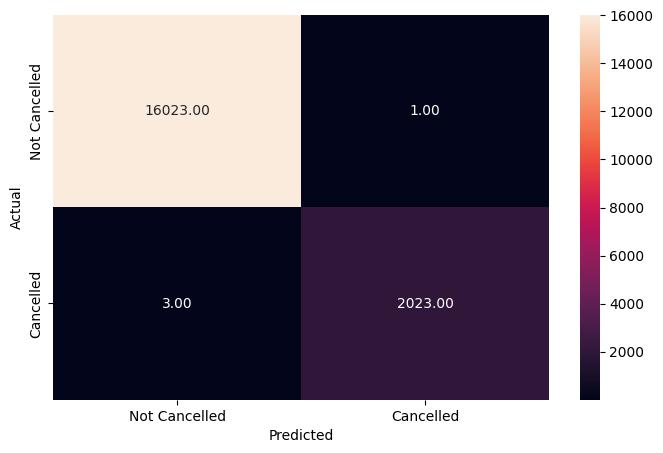

In [439]:
metrics_score(y_test, y_pred)

In [440]:
x_train_encoded.columns

Index(['code_agent', 'code_formule', 'code_produit_gestion',
       'code_marque_vehicule', 'libelle_modele_vehicule', 'numero_tarif',
       'puissance_fiscale', 'situation_familiale', 'departement', 'region',
       'libelle_modele_vehicule_groupe_1', 'code_formule_groupe',
       'code_marque_vehicule_groupe_2', 'numero_tarif_groupe2',
       'code_csp_groupe_1', 'region_groupe', 'code_marche_T', 'sexe_M',
       'sexe_missing', 'code_usage_auto_groupe_Usage_frequent',
       'code_usage_auto_groupe_Usage_rare',
       'libelle_modele_vehicule_groupe_2_tres_repandu',
       'code_agent_groupe_moyen_fort', 'code_agent_groupe_rare',
       'code_agent_groupe_tres_repandu', 'code_produit_gestion_groupe_AUTRES',
       'code_marque_vehicule_groupe_1_rare',
       'code_marque_vehicule_groupe_1_tres_repandue',
       'numero_tarif_groupe_rare', 'numero_tarif_groupe_tres_courant_BL050',
       'numero_tarif_groupe_tres_courant_BL064', 'code_csp_groupe_2_rare',
       'code_csp_groupe_2_tr